In [16]:
import torch
import torch.nn as nn
import torchvision

import numpy as np

from prep_data import process_img

from preprocess import generate_normalizer

from helpers import random_file, get_species, show_img

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
test_img_path = 'Pollen Slides/Acmispon glaber/06-10-15/AG061015 40X1A 782.JPG'

main_dir = 'Pollen Slides'

# # uncomment to use a random image from the `Pollen Slides` folder
# test_img_path = random_file('Pollen Slides')

load_path = 'Models/pollen-model.pt'

In [9]:
checkpoint = torch.load(load_path, map_location=device)

data_transforms = checkpoint['data_transforms']
dataloaders = checkpoint['dataloaders']
class_names = dataloaders['train'].dataset.classes

dataset_sizes = {x: len(dataloaders[x].dataset.imgs) for x in ['train', 'val']}

In [17]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  # tells the model not to change this part of network (don't compute gradient over weights)
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
# number of features activates in network, number classes
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

# load model onto device
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

model_conv.load_state_dict(checkpoint['model_state_dict'])
model_conv.eval()
model_conv.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
def predict(image, with_class=False, with_output=False):
  res = []

  transformed = data_transforms['val'](image).float()
  transformed = transformed.unsqueeze_(0)

  input_img = transformed.to(device)
  output = model_conv(input_img)

  idx = output.data.cpu().numpy().argmax()
  res.append(idx)
  if with_class: res.append(class_names[idx])
  if with_output: res.append(output)
  
  if len(res) > 1: return tuple(res)
  else: return res[0]

In [19]:
true_species = get_species(test_img_path, main_dir=main_dir)

label = class_names.index(true_species)

In [20]:
normalizer = generate_normalizer()

try:
  samples = process_img(test_img_path, normalizer=normalizer)
except Exception as e:
  print(e)

sample predictions: ['Acmispon glaber', 'Acmispon glaber', 'Acmispon glaber']


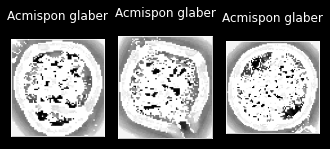

losses: [0.09, 0.0, 0.0]


In [22]:
preds = []
losses = []

for img in samples:
  pred, output = predict(img, with_output=True)

  loss = round(criterion(output, torch.tensor([label], device=device)).item(), 2)
  
  preds.append(pred)
  losses.append(loss)

print('sample predictions:', [f'{class_names[pred]}' for pred in preds])

show_img([np.asarray(img) for img in samples], title=[f'{class_names[pred]}' for pred in preds])

print('losses:', losses)

In [23]:
if len(set(preds)) == 1: top_pred = preds[0]
else: top_pred = max(set(preds), key=preds.count)

sample_acc = round(preds.count(top_pred)/len(preds), 2)

pred_species = class_names[top_pred]

print(f'true species: {true_species} / top prediction: {pred_species} ({true_species==pred_species})\nsample accuracy: {sample_acc}')

true species: Acmispon glaber / top prediction: Acmispon glaber (True)
sample accuracy: 1.0
